In [411]:
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyabf
import pandas as pd
from scipy.signal import medfilt
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
from sklearn.cluster import KMeans
from sklearn import metrics


In [708]:
## Synaptic Connectivity (Paired Recording)
data_path = '../data/1_CrayfishNeuromuscularJunction/lab3/21915007.abf' ## paired, no splash
data_tmp = pyabf.ABF(data_path)
data_tmp

ABF (v2.6) with 2 channels (uV, mV), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 0.31 minutes, recorded without a protocol file. path=/Users/gilikarni/Documents/pni-courses/501b/data/1_CrayfishNeuromuscularJunction/lab3/21915007.abf

In [413]:
print(type(data_tmp))
print(data_tmp)

<class 'pyabf.abf.ABF'>
ABF (v2.6) with 2 channels (uV, mV), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 0.31 minutes, recorded without a protocol file.


In [414]:
# nerve extracellular recording
data_tmp.setSweep(sweepNumber=0, channel=0) 
nerve_v = data_tmp.sweepY
nerve_label = data_tmp.sweepLabelY

times = data_tmp.sweepX # time in seconds!  we don't have to worry about the time array

# muscle intracellular recording
data_tmp.setSweep(sweepNumber=0, channel=1) 
muscle_v = data_tmp.sweepY
muscle_label = data_tmp.sweepLabelY


print(nerve_label, nerve_v)
print(muscle_label, muscle_v)
print(times)

Suction (uV) [46.3867 54.3213 36.6211 ...  2.4414  0.9155 -2.4414]
Membrane Potential (mV) [0.0305 0.     0.     ... 0.7935 0.7629 0.7324]
[ 0.      0.0001  0.0002 ... 18.5853 18.5854 18.5855]


In [415]:
len(times)/max(times) 
#voila 10khz

10000.05380538592

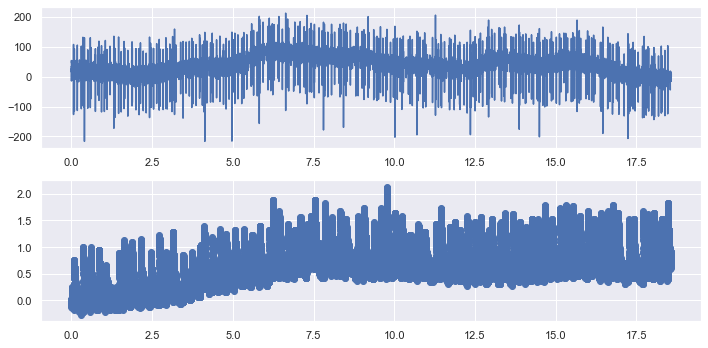

In [422]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharey=False)

axes[0].plot(times, nerve_v)
axes[1].scatter(times, muscle_v)

plt.tight_layout()
plt.show()

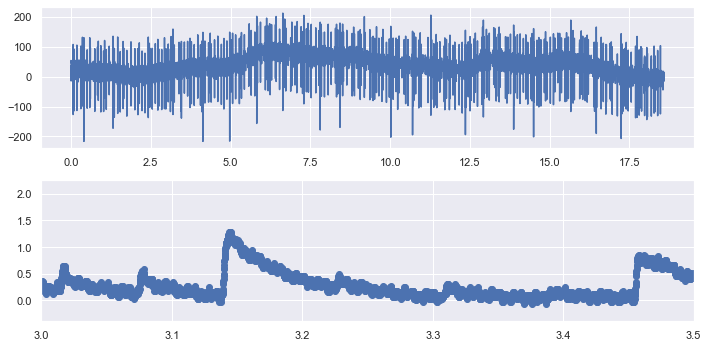

In [426]:
# ## zoom in
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharey=False)

axes[0].plot(times, nerve_v)
axes[1].scatter(times, muscle_v)

plt.xlim(3,3.5)
plt.tight_layout()
plt.show()

Filtering

In [429]:
correction_m = medfilt(muscle_v, kernel_size=801)
muscle_v_filt = muscle_v - correction_m + np.median(muscle_v)

correction_n = medfilt(nerve_v, kernel_size=801)
nerve_v_filt = nerve_v - correction_n + np.median(nerve_v)

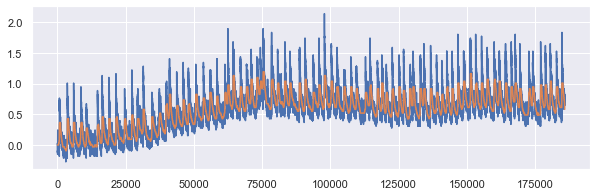

In [430]:

plt.plot(muscle_v)
plt.plot(correction_m)
plt.show()


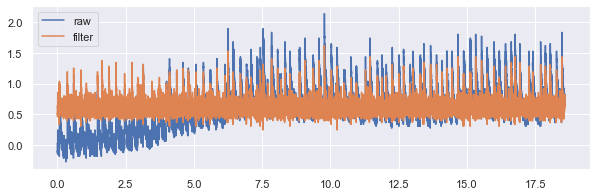

In [432]:
#sns.set(rc={'figure.figsize':(10,3)})

plt.plot(times, muscle_v, label = 'raw')
plt.plot(times, muscle_v_filt, label = 'filter')

plt.legend()

plt.show()

spike sorting

In [672]:
peaks,_ = find_peaks(nerve_v_filt, height=60, distance=30)
## 30 for rfractory period

# get non edge peaks
waveforms = []
non_edge_peaks = []

edge = 2000
window = 10

for peak in peaks:
    if(peak>=edge and peak<=len(nerve_v_filt)-edge): #edge cases ignored
        waveforms.append(nerve_v_filt[peak-window:peak+window])
        non_edge_peaks.append(peak)

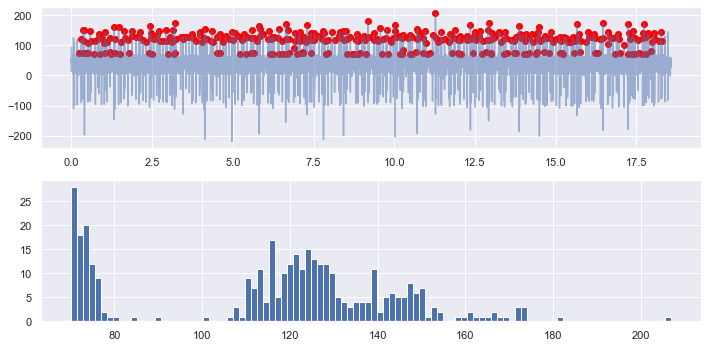

In [674]:
peak_heights = nerve_v_filt[non_edge_peaks]


fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharey=False)

axes[0].plot(times, nerve_v_filt, alpha=0.5)
axes[0].scatter(times[non_edge_peaks], peak_heights, c='red')

axes[1].hist(peak_heights, bins=100)

plt.tight_layout()

#plt.xlim(40000,45000)
#plt.ylim(-100,100)

plt.show()

## highly correalted with peak finder params
# & need a better peak finder function! consider unsupervised

clustering - option 1 : peak finder

In [675]:
all_km = []
sil_score = []
for k in [2,3,4,5,6]:
    km1 = KMeans(n_clusters=k).fit(peak_heights.reshape([-1,1]))
    all_km.append(km1.labels_)
    

<Figure size 720x216 with 0 Axes>

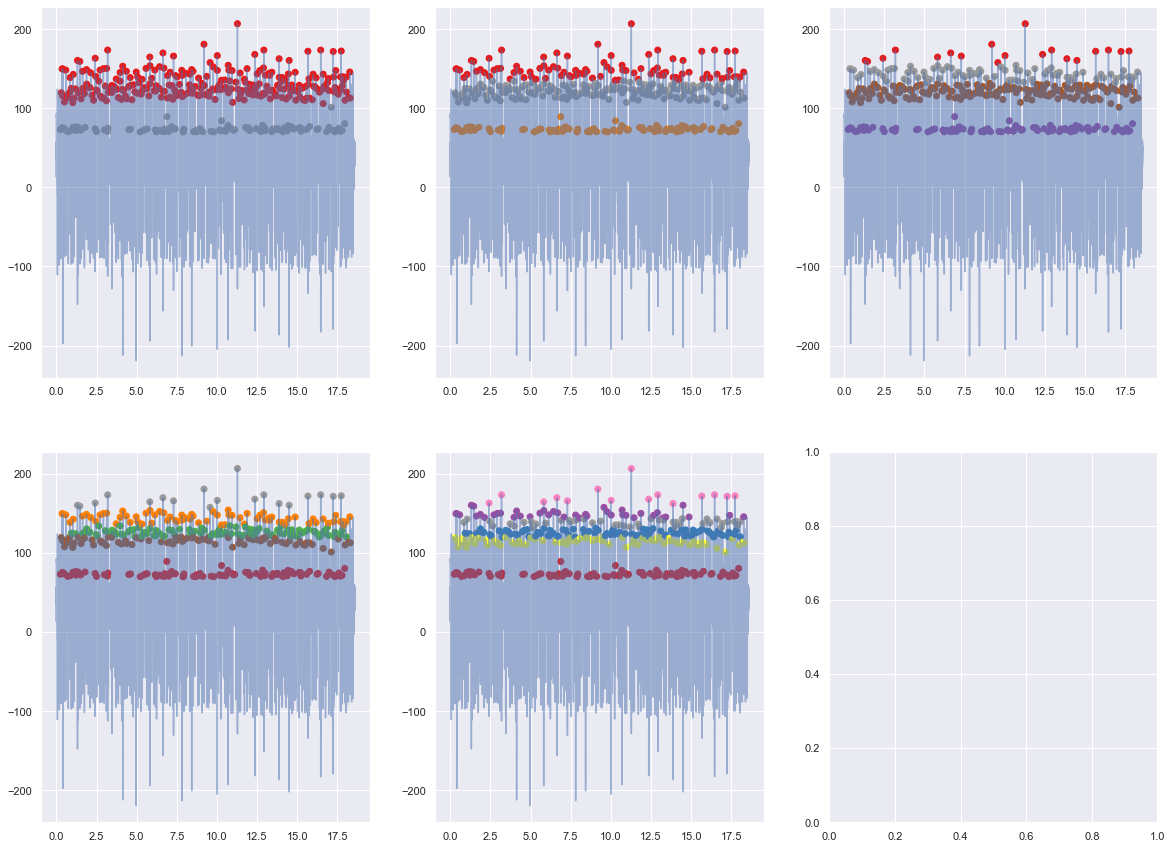

In [677]:
plt.set_cmap('Set1')
fig, axs = plt.subplots(2,3, figsize=(20, 15),)

axs = axs.ravel()

for i in range(5):
    axs[i].plot(times, nerve_v_filt, alpha=0.5)
    axs[i].scatter(times[non_edge_peaks], peak_heights, c=all_km[i])


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/f

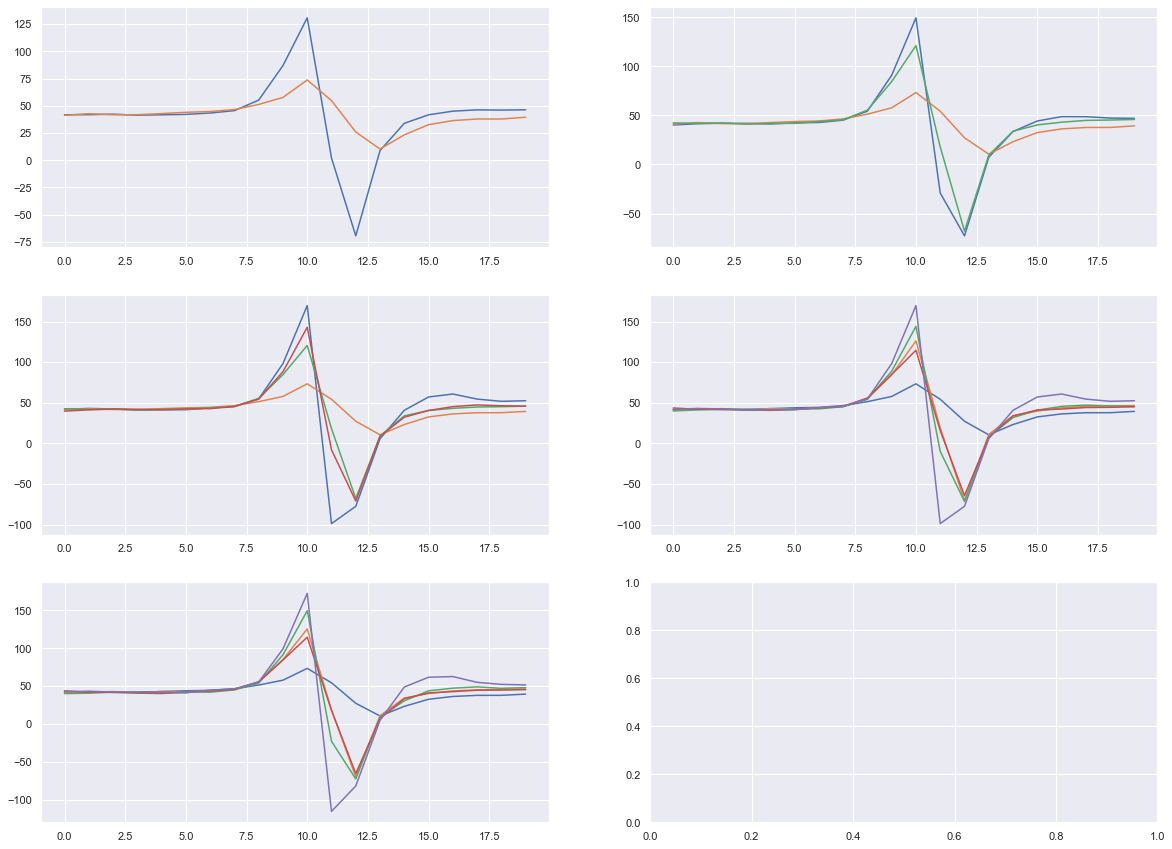

In [678]:
fig, axs = plt.subplots(3,2, figsize=(20, 15),)
axs = axs.ravel()

for i in range(5):
    for j in range(5):
        axs[i].plot(np.mean(M[all_km[i]==j],axis=0))
        #axs[i].set_xlim(90,110)
plt.show()

clustering - option 2 : wave form

In [679]:

M = np.array(waveforms)
covariance_matrix=np.cov(M.T)


In [680]:
M.shape # N peaks, each with T timestamps
covariance_matrix.shape # T*T vairance of each timestamp along the waves.


(20, 20)

In [681]:
u, s, vh = np.linalg.svd(covariance_matrix) ### svd of covaraince matrix


In [710]:
Mo = M-np.mean(M, axis=0) 
projection_on_PC1=np.dot(Mo,u[:,0])
projection_on_PC2=np.dot(Mo,u[:,1])
projection_on_PC3=np.dot(Mo,u[:,2])

pc_X = np.array([projection_on_PC1, projection_on_PC2]).T


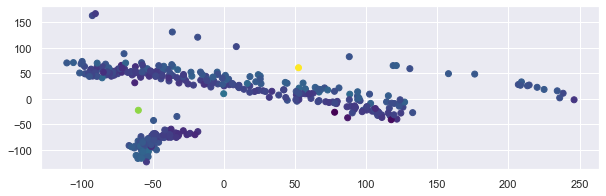

In [683]:
plt.set_cmap('viridis')
plt.scatter(projection_on_PC1, projection_on_PC2, c = np.dot(Mo,u[:,2]))


In [714]:
all_km_pc = []
tmp_average_distance = []
for k in [2,3,4,5,6]:
    km2 = KMeans(n_clusters=k).fit(pc_X.reshape([-1,1]))
    all_km_pc.append(km2.labels_)

    

In [716]:
all_km_pc[i]

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

ValueError: 'c' argument has 730 elements, which is inconsistent with 'x' and 'y' with size 365.

<Figure size 720x216 with 0 Axes>

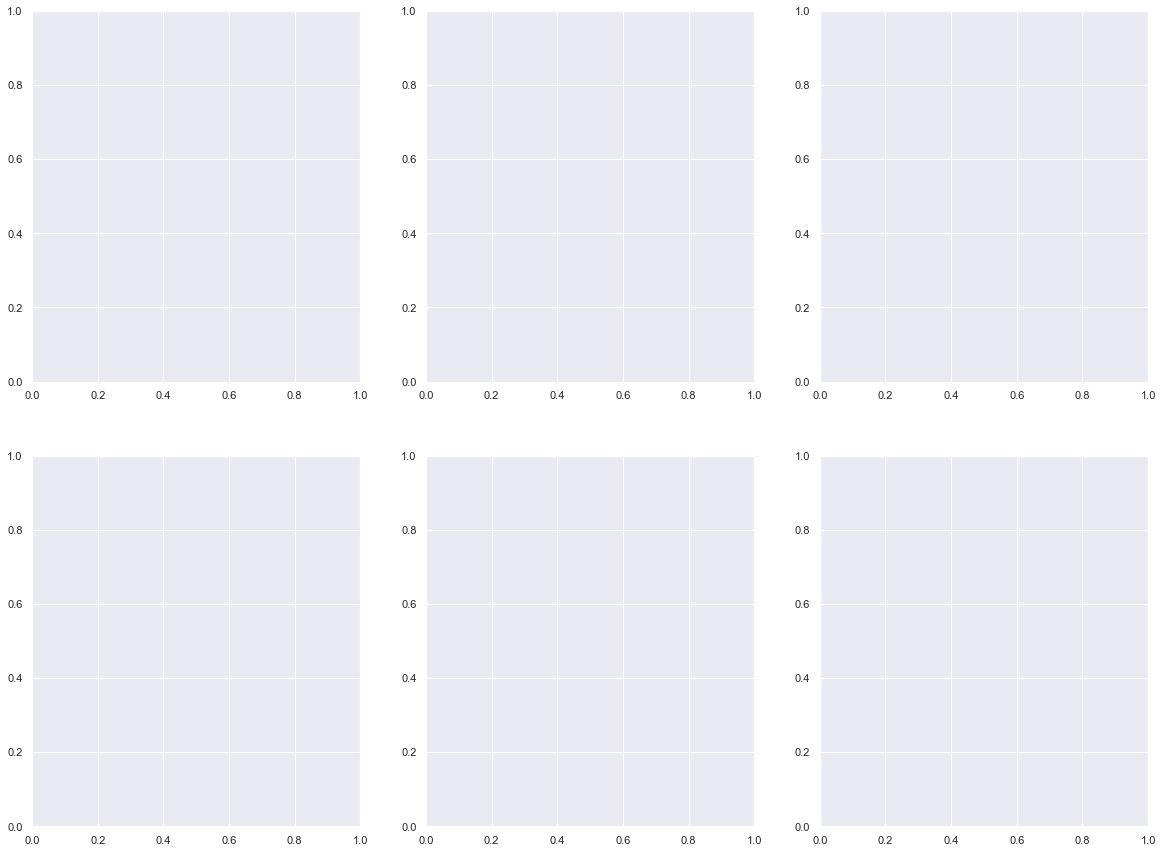

In [715]:
plt.set_cmap('Set1')
fig, axs = plt.subplots(2,3, figsize=(20, 15),)

axs = axs.ravel()

for i in range(5):
    axs[i].scatter(projection_on_PC1, projection_on_PC2,
                c=all_km_pc[i])



In [640]:

# fig, axs = plt.subplots(5,2, figsize=(20, 15),)
# axs = axs.ravel()

# pl_ax=0
# for i in range(5):
#     for j in range(5):
#         axs[pl_ax].plot(np.mean(M[all_km_pc[i]==j],axis=0))
        
#     axs[pl_ax+1].bar(range(i+2),
#                     [np.mean(peak_heights[all_km[i]==p], axis=0) for p in range(i+2)])
    
#     pl_ax += 2  
#     pl_ax += 1 


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/f

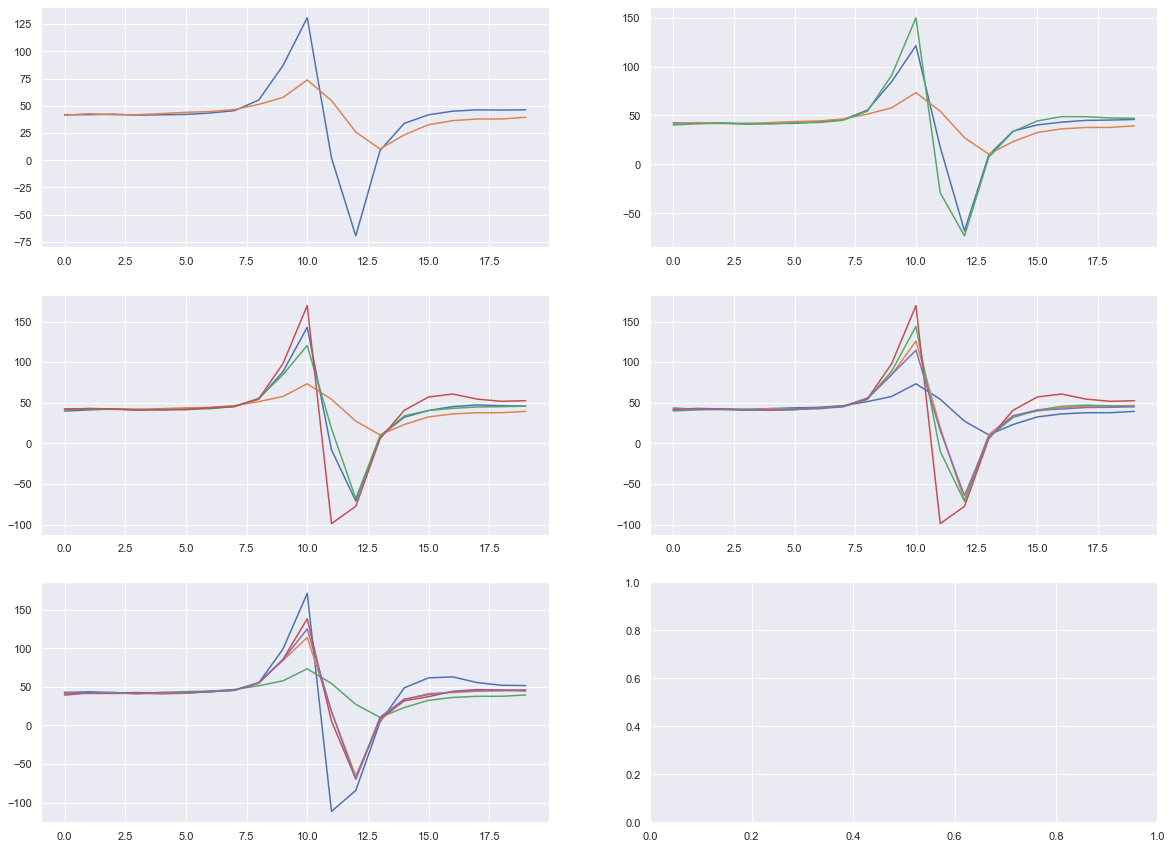

In [686]:
fig, axs = plt.subplots(3,2, figsize=(20, 15),)
axs = axs.ravel()

for i in range(5):
    for j in range(5):
        axs[i].plot(np.mean(M[all_km_pc[i]==j],axis=0))
        #axs[i].set_xlim(90,110)
plt.show()

JP//AP

(5.0, 6.0)

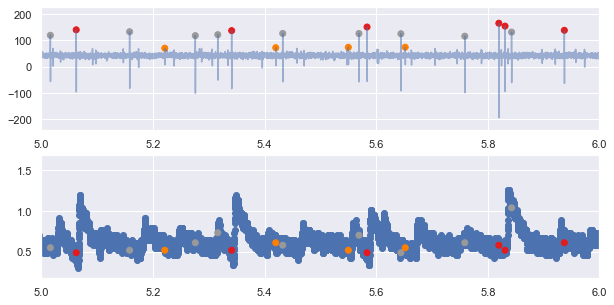

In [704]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharey=False)

axes[0].plot(times, nerve_v_filt, alpha=0.5)
axes[0].scatter(times[non_edge_peaks], peak_heights, c=all_km[1])

axes[1].scatter(times, muscle_v_filt)
axes[1].scatter(times[non_edge_peaks], muscle_v_filt[non_edge_peaks],c=all_km[1])



axes[0].set_xlim(5,6)
axes[1].set_xlim(5,6)